In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math as math
from scipy.optimize import minimize
import scipy.stats as ss
from scipy.signal import find_peaks 
from matplotlib import rc
from scipy.optimize import fsolve

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#en figur der fylder en kolonne har bredde 5,8, f.eks: fig, ax= plt.subplots(figsize=(5.8,4))
#en figur der fylder to kolonner har dobbeltbredde??

In [2]:
#til at slå op i masses.dat
data = np.transpose(np.loadtxt("masses.txt"))

N=data[0]
Z=data[1]
A=data[2]
massExcess=data[3]
bEPrNkl=data[4]

mp = 938.272*1000
me = 0.510998*1000
mn = 939.565*1000

def me2(a, z):
    a_indices = np.where(A == a)
    z_indices = np.where(Z == z)
    a = lambda: print('Could not find mass excess for given numbers')
    for i in range(len(a_indices[0])):
        if np.any(z_indices[0] == a_indices[0][i]):
            me = bEPrNkl[a_indices[0][i]]
            a = lambda: me
    return a()

def m2(a,z): 
    return mp*z+(a-z)*mn-me2(a,z)*a

mp = 938272.08816
mAl = m2(27,13)
mO = m2(16,8)
mN16 = m2(16,7)
mC13 = m2(13,6)
mO17 = m2(17,8)
mO18 = m2(18,8)
mN15 = m2(15,7)
mN14 = m2(14,7)
mN = m2(15,7)
mC = m2(12,6)
mHe = m2(4,2)
mF = m2(19,9)
mMg = m2(24,12)
mLi = m2(7,3)

In [47]:
p0s = [np.array([ 11.6571203 , -10.38504481,  -7.04353266,  -2.37858732,
         -0.45398408]),
 np.array([15.79805371, -8.82074153, -6.96671492, -1.8115817 , -3.54545702]),
 np.array([ 17.30183933, -11.2267975 , -12.41672887,  -4.54375525,
         -2.47219388]),
 np.array([ 18.18618777, -10.58403106, -14.55914395,  -4.03807754,
         -3.49934203]),
 np.array([ 14.83348749,  -9.3608994 , -16.55671261,  -5.11280818,
         -2.78823956]),
 np.array([ 10.05884654,  -6.71100039, -17.04426234,  -5.71080167,
         -0.90776011]),
 np.array([  4.71254631,  -3.81929123, -11.14556824,  -4.75822071,
          0.40930473]),
 np.array([ 3.53969993, -3.36077637, -9.85757745, -4.55919011,  0.29258296]),
 np.array([ 2.74194896, -2.49993907, -7.88363804, -4.32829959,  0.43719598]),
 np.array([  8.57360662, -14.82547577, -11.98314725, -21.60896734,
          2.06916749]),
 np.array([  7.62199895, -18.74722544,  -1.168546  , -22.33745215,
         -5.29504497]),
 np.array([  2.04325958, -14.30759767,  -0.17664503, -18.26695244,
         -7.72381716]),
 np.array([ 0.31358423, -0.19013472,  0.11601773, -0.11922477,  0.0920409 ])]

In [100]:
#jeg vil loope over alle vinkelfordelinger
GVs = [813,835,860,880,898,920,950,975,1000,1034,1045,1055,1400]

angles = []
cosangles = []
counts = []
solid = []
VCharge = []

for i in range(len(GVs)):
    data = np.transpose(np.loadtxt('AngCross/angCross' + str(GVs[i]) +'.txt', skiprows=1))
    angles.append(data[0])
    cosangles.append(np.cos(data[0]*2*np.pi/360))
    counts.append(data[3])
    solid.append(data[4])
    VCharge.append(data[5][0])
    
angCrosses = []
angCrossErrs = []

solidAngleErrs = np.transpose(np.loadtxt('SolidAngleErrors.txt',skiprows = 1))[4]

#beregn cross section og fejl
for i in range(len(GVs)):
    N_shot = VCharge[i]*5.85e7 * 1/0.93 #0.95 fra kalibrering
    rt = 0.4*20e-6/(0.6*12+0.4*15)*6.022*1e23*1e4* 1/np.cos(2*np.pi/360*35) #5/12 * 2.26e6  * 6.022*10e23 / 15 * 40e-9  * 1/np.cos(np.pi/4)
    directCross = counts[i] / (N_shot * rt * solid[i]) * 1e31
    rtError = rt*0.05 #antag en fejl på 5% på tykkelsen. Dermed bliver der også en fejl på 5% på rt.
    countError = np.sqrt(counts[i])
    N_shotError = 0.03*N_shot
    solidAngError = solidAngleErrs
    crossError = directCross * np.sqrt( (countError/counts[i])**2 + (rtError/rt)**2 + (N_shotError/N_shot)**2 +(countError/counts[i])**2 + (solidAngError/solid[i])**2)
    angCrossErrs.append(crossError)
    angCrosses.append(directCross)
    
def legendreSum(x,a,b,c,d,e):
    return a+b*x+c*1/2*(3*x**2-1) + d * 1/2*(5*x**3-3*x) + e * 1/8 * (63*x**5 - 70* x**3 + 15*x)
    
popts = []
totalCross = []
totalCrossErr = []
for i in range(len(GVs)):
    #cosangles[i] = np.append(cosangles[i],1)
    #angCrosses[i] = np.append(angCrosses[i],0)
    #angCrossErrs[i] = np.append(angCrossErrs[i],1)
    popt, pcov = curve_fit(legendreSum,cosangles[i],angCrosses[i],p0=p0s[i],sigma=angCrossErrs[i], absolute_sigma = True)
    popts.append(popt)
    totalCross.append(popt[0])
    totalCrossErr.append(np.sqrt(np.diag(pcov))[0])
totalCross

[11.880663642957584,
 15.895768333234395,
 17.37233351477167,
 18.399218536015088,
 14.906916253283605,
 10.3809579678119,
 4.940241531793014,
 3.938964066984067,
 2.911042182598,
 9.482580591129102,
 8.658799429228864,
 3.299887261525464,
 0.3295477522047975]

In [91]:
solidAngleErrs = np.transpose(np.loadtxt('SolidAngleErrors.txt',skiprows = 1))

In [92]:
print(GVs[3]*1.169)
print(GVs[10]*1.169)
popts

1028.72
1221.605


[array([11.88066364, -9.97669814, -6.5095218 , -1.95071445, -0.77843068]),
 array([15.89576833, -8.65223179, -6.73633835, -1.63882899, -3.71190815]),
 array([ 17.37233351, -11.17515476, -12.36492024,  -4.43813565,
         -2.65326241]),
 array([ 18.39921854, -10.24229191, -14.14065444,  -3.59697631,
         -3.84706593]),
 array([ 14.90691625,  -9.39954049, -16.62880048,  -5.01277188,
         -3.07066957]),
 array([ 10.38095797,  -6.53606   , -16.82846841,  -5.07480683,
         -1.73819441]),
 array([  4.94024153,  -3.64197885, -10.8853071 ,  -4.2245478 ,
         -0.13004631]),
 array([ 3.93896407, -2.80583615, -9.05842788, -3.56408549, -0.46915515]),
 array([ 2.91104218, -2.27167493, -7.52207497, -3.8670361 ,  0.06859231]),
 array([  9.48258059, -12.51302182,  -9.28381864, -18.1634612 ,
          1.38377396]),
 array([  8.65879943, -13.9260021 ,   1.28083244, -13.92649552,
         -0.33912721]),
 array([ 3.29988726, -7.45683422,  2.76581865, -6.78599603, -1.03693605]),
 array([ 

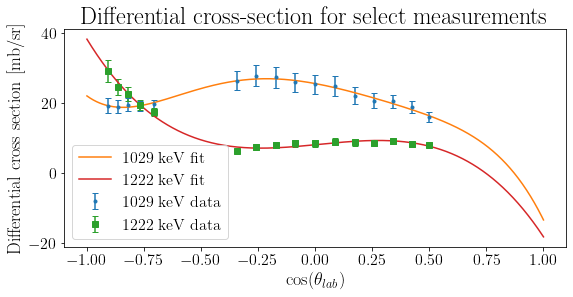

In [102]:
i = 3
space = np.linspace(-1,1,1000)
fig, ax = plt.subplots(figsize = [9,4])
ax.set_xlabel(r'$\cos(\theta_{lab})$')
ax.errorbar(cosangles[i][0:-1],angCrosses[i][0:-1],yerr=angCrossErrs[i][0:-1],fmt='.',capsize=3, label='1029 keV data')
ax.plot(space,legendreSum(space,*popts[i]),label = '1029 keV fit')
i = 10
ax.errorbar(cosangles[i][0:-1],angCrosses[i][0:-1],yerr=angCrossErrs[i][0:-1],fmt='s',capsize=3, label='1222 keV data')
ax.plot(space,legendreSum(space,*popts[i]),label = '1222 keV fit')
ax.set_ylabel('Differential cross section [mb/sr]')
ax.set_title(r'Differential cross-section for select measurements')
ax.legend()
#plt.savefig('txtHists/angCross.png',dpi=300, bbox_inches = 'tight',facecolor='white', transparent=False)

In [103]:
#jeg kunne godt tænke mig at lave fits med Breit-Wigner formlen. 
def BreitWigner(x,Er,W,a):
    return a/((x-Er)**2+W**2/4)

def BreitWignerSum(x,Er1,W1,a1,Er2,W2,a2):
    return BreitWigner(x,Er1,W1,a1)+BreitWigner(x,Er2,W2,a2)

pEnsToFit = []
crossToFit = []
errsToFit = []
for i in range(len(GVs)):
    if(GVs[i]*1.169 < 1250):
        pEnsToFit.append(GVs[i]*1.169)
        crossToFit.append(totalCross[i])
        errsToFit.append(totalCrossErr[i])

popt, pcov = curve_fit(BreitWignerSum,pEnsToFit,crossToFit,[4,4,4,4,4,4],errsToFit, absolute_sigma = True,maxfev = 10000)

In [104]:
def exOcalc(accE,mb,mt,mO):
    beta = np.sqrt(((accE+mb)**2-mb**2))/(accE+mb+mt)
    pz = np.sqrt((accE+mb)**2-mb**2)
    en = accE + mb + mt
    gamma = 1/np.sqrt(1-beta**2)
    pzCM = gamma*(pz - beta*en)
    enCM = gamma*(en - beta*pz)
    return enCM - mO

o16excitations = exOcalc(1.169*np.array(GVs),mp,mN,mO)
o16excitations

array([13017.96260782, 13042.06043606, 13069.4442845 , 13091.35132704,
       13111.06763781, 13135.16531555, 13168.02572242, 13195.40933949,
       13222.79290626, 13260.03447635, 13272.0831997 , 13283.03657611,
       13660.92313425])

[12971.0, 13018.0, 13064.0, 13111.0, 13158.0, 13205.0, 13252.0, 13299.0]

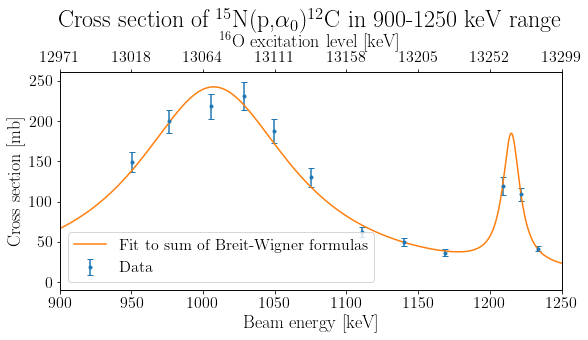

In [105]:
#plt.plot(1.167*GV,cross,'.')
pEnLinspace = np.linspace(900,1250,1000)
fig, ax = plt.subplots(figsize = [9,4])
ax.set_xlabel('Beam energy [keV]')

ax.errorbar(1.169*np.array(GVs),4*np.pi*np.array(totalCross),4*np.pi*np.array(totalCrossErr), fmt = '.', capsize = 3, label='Data')
ax.plot(pEnLinspace,4*np.pi*BreitWignerSum(pEnLinspace,*popt), label = 'Fit to sum of Breit-Wigner formulas')

ax.set_xlim(900,1250)

ax.set_ylabel('Cross section [mb]')
ax.set_title(r'Cross section of $^{15}$N(p,$\alpha_0$)$^{12}$C in 900-1250 keV range')

ax2 = ax.twiny()
ax2.set_xticks( ax.get_xticks() )
ax2.set_xbound(ax.get_xbound())
ax2.set_xticklabels([int(exOcalc(x,mp,mN,mO)+0.5) for x in ax.get_xticks()])
ax2.set_xlabel(r'$^{16}$O excitation level [keV]')

ax.legend()
plt.savefig('txtHists/a0energyScan.png',dpi=300, bbox_inches = 'tight',facecolor='white', transparent=False)
[np.rint(exOcalc(x,mp,mN,mO)) for x in ax.get_xticks()]

In [106]:
popt

array([ 1.00744046e+03,  1.31633829e+02,  8.35189527e+04,  1.21488720e+03,
       -1.46223850e+01,  6.92203283e+02])

In [147]:
np.sqrt(np.diag(pcov))

array([1.47849716e+00, 3.93608180e+00, 4.43751099e+03, 2.61479653e-01,
       1.71115812e+00, 9.67047152e+01])

In [154]:
exOcalc(popt[3],mp,mN,mO)-exOcalc(popt[3]+.26,mp,mN,mO)

-0.24361678212881088

In [155]:
exOcalc(popt[3],mp,mN,mO)

13265.342781618237

In [150]:
exOcalc(popt[0],mp,mN,mO)-exOcalc(popt[0]-1.47,mp,mN,mO)

1.3773893844336271

In [185]:
#skulle dataet tages om ville det være interessant at gøre det ved følgende energier:
energies = [900,950,975,1000,1010,1020,1030,1040,1050,1075,1100,1150,1175,1200,1210,1215,1220,1225,1230,1250]

In [186]:
newGVs = np.array(energies)/1.169
newGVs

array([ 769.88879384,  812.6603935 ,  834.04619333,  855.43199316,
        863.98631309,  872.54063302,  881.09495295,  889.64927288,
        898.20359281,  919.58939264,  940.97519247,  983.74679213,
       1005.13259196, 1026.51839179, 1035.07271172, 1039.34987169,
       1043.62703165, 1047.90419162, 1052.18135158, 1069.28999145])

3.64969696969697e+21
5.161450953097441e+21


(0.0, 40.0)

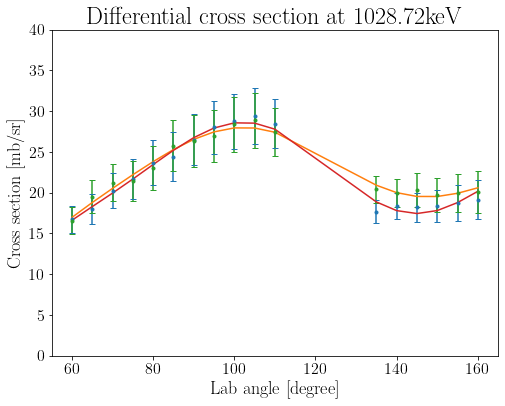

In [300]:
data = np.transpose(np.loadtxt('AngCross/angCross879.txt', skiprows=1))
angles879 = data[0][6:]
cosangles879 = np.cos(data[0]*2*np.pi/360)[6:]
counts879 = data[3][6:]
solid879 = data[4][6:]
VCharge879 = data[5][0]
N_shot = VCharge879*5.85e7 * 1/0.95 #0.95 fra kalibrering
rt = 0.4*20e-6/(0.6*12+0.4*15)*6.022*1e23*1e4* 1/np.cos(2*np.pi/360*45)
directCross = counts879 / (N_shot * rt * solid879) * 1e31
rtError = rt*0.05 #antag en fejl på 5% på tykkelsen. Dermed bliver der også en fejl på 5% på rt.
countError = np.sqrt(counts879)
N_shotError = 0.05/0.95**2*N_shot
solidAngError = solidAngleErrs
crossError = directCross * np.sqrt( (countError/counts879)**2 + (rtError/rt)**2 + (N_shotError/N_shot)**2 + (solidAngError/solid879)**2)

popt, pcov = curve_fit(legendreSum,cosangles879,directCross,[4,4,4,4,4],crossError, absolute_sigma = True)

space = np.linspace(-1,1,1000)
fig, ax = plt.subplots(figsize = [8,6])
ax.set_xlabel('Lab angle [degree]')
ax.errorbar(angles879,directCross,yerr=crossError,fmt='.',capsize=3)
ax.plot(angles879,legendreSum(np.cos(2*np.pi/360*angles[3]),*popts[3]))
ax.errorbar(angles[3],angCrosses[3],yerr=angCrossErrs[3],fmt='.',capsize=3)
ax.plot(angles879,legendreSum(np.cos(2*np.pi/360*angles[i]),*popt))
ax.set_ylabel('Cross section [mb/sr]')
ax.set_title(r'Differential cross section at ' + str(GV[3]*1.169) + 'keV')
ax.set_ylim(0,40)

In [299]:
popt

array([ 18.53746146, -10.90808139, -16.41802057,  -4.72494375,
        -6.51649204])

Text(0.5, 1.0, 'Differential cross section at 1028.72keV')

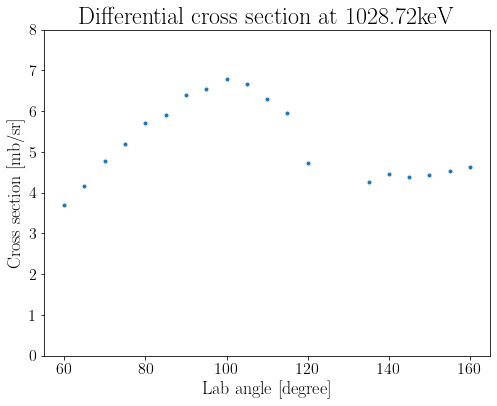

In [140]:
data = np.transpose(np.loadtxt('AngCross/angCross879.txt', skiprows=1))
angles879 = data[0][6:]
cosangles879 = np.cos(data[0]*2*np.pi/360)[6:]
counts879 = data[3][6:]
solid879 = data[4][6:]
VCharge879 = data[5][0]
N_shot = VCharge879*5.85e7 * 1/0.95 #0.95 fra kalibrering
rt = 5/12 * 2.26e6  * 6.022*10e23 / 15 * 40e-9  * 1/np.cos(np.pi/4)
directCross = counts879 / (N_shot * rt * solid879) * 1e31
popt, pcov = curve_fit(legendreSum,cosangles879,directCross,[4,4,4,4,4])

space = np.linspace(-1,1,1000)
fig, ax = plt.subplots(figsize = [8,6])
ax.set_xlabel('Lab angle [degree]')
ax.plot(angles879,directCross,'.')
ax.set_ylim(0,8)
ax.set_ylabel('Cross section [mb/sr]')
ax.set_title(r'Differential cross section at ' + str(GV[i]*1.169) + 'keV')

In [150]:
#ratioen mellem directcounts og vcharge ved 90 grader er 0,16 ved 879gv
#ved 880gv er den 0.13

In [151]:
0.16/0.13

1.2307692307692308

In [ ]:
#det er herfra den faktor, der er forskellen på de to plots kommer.

In [16]:
fractions = []
fractionErrs = []
alpha1crosses = []
alpha1crossesErr = []

for i in range(len(GVs)):
    data = np.loadtxt('AngCross/alpha1Fraction' + str(GVs[i]) + '.txt',skiprows = 1)
    alpha0s = data[2]
    alpha1s = data[0]
    alpha1Err = data[1]
    fraction = alpha1s/alpha0s
    alpha1Err = alpha1Err if alpha1Err > np.sqrt(alpha1s) else np.sqrt(alpha1s)
    fractionErr = fraction * np.sqrt( (1/alpha0s) + (alpha1Err/alpha1s)**2)
    alpha1cross = fraction*totalCross[i]
    alpha1crossErr = alpha1cross * np.sqrt( (fractionErr/fraction)**2 + (totalCrossErr[i]/totalCross[i])**2 )
    fractions.append(fraction)
    fractionErrs.append(fractionErr)
    alpha1crosses.append(alpha1cross)
    alpha1crossesErr.append(alpha1crossErr)

In [17]:
#jeg kunne godt tænke mig at lave fits med Breit-Wigner formlen. 
def BreitWigner(x,Er,W,a):
    return a/((x-Er)**2+W**2/4)

def BreitWignerSum(x,Er1,W1,a1,Er2,W2,a2):
    return BreitWigner(x,Er1,W1,a1)+BreitWigner(x,Er2,W2,a2)

pEnsToFit = []
crossToFit = []
errsToFit = []
for i in range(len(GVs)):
    if(GVs[i]*1.169 < 1250):
        pEnsToFit.append(GVs[i]*1.169)
        crossToFit.append(alpha1crosses[i])
        errsToFit.append(alpha1crossesErr[i])

popt, pcov = curve_fit(BreitWignerSum,pEnsToFit,crossToFit,[1000,100,4,1220,20,4],errsToFit, absolute_sigma = True,maxfev = 10000)

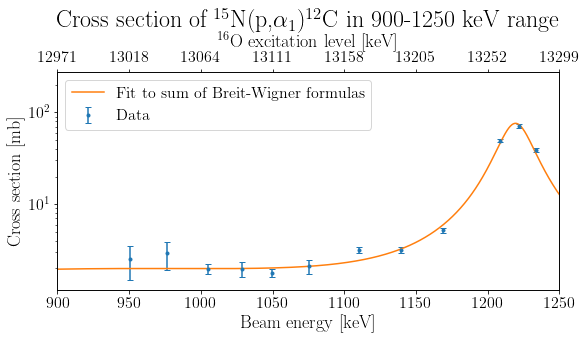

In [24]:
pEnLinspace = np.linspace(900,1250,1000)
fig, ax = plt.subplots(figsize = [9,4])
ax.set_xlabel('Beam energy [keV]')
ax.errorbar(1.169*np.array(GVs),4*np.pi*np.array(alpha1crosses),4*np.pi*np.array(alpha1crossesErr), fmt = '.', capsize = 3, label='Data')

ax.plot(pEnLinspace,4*np.pi*BreitWignerSum(pEnLinspace,*popt), label = 'Fit to sum of Breit-Wigner formulas')

ax.set_xlim(900,1250)

ax2 = ax.twiny()
ax2.set_xticks( ax.get_xticks() )
ax2.set_xbound(ax.get_xbound())
ax2.set_xticklabels([int(exOcalc(x,mp,mN,mO)+0.5) for x in ax.get_xticks()])
ax2.set_xlabel(r'$^{16}$O excitation level [keV]')

ax.set_yscale('log')
ax.set_ylabel('Cross section [mb]')
ax.set_title(r'Cross section of $^{15}$N(p,$\alpha_1$)$^{12}$C in 900-1250 keV range')
ax.legend()
plt.savefig('txtHists/a1energyScan.png',dpi=300, bbox_inches = 'tight',facecolor='white', transparent=False)

In [206]:
popt

array([  913.01284138,  -662.61904324, 16037.58541927,  1219.35859657,
         -26.44625377,  1043.99867494])

In [207]:
np.sqrt(np.diag(pcov))

array([5.46387214e+02, 1.06868484e+03, 6.16740155e+04, 4.45996311e-01,
       1.56322990e+00, 1.01482471e+02])

In [219]:
data = np.transpose(np.loadtxt('txts/Alphas880.txt'))
alphas880 = data[0]
data = np.transpose(np.loadtxt('txts/Alphas1045.txt'))
alphas1045 = data[0]

alphas880sorted = []
alphas1045sorted = []

for i in range(len(alphas1045)):
    if(alphas1045[i] < 1400 and alphas1045[i] > 800):
        alphas1045sorted.append(alphas1045[i])
        
for i in range(len(alphas880)):
    if(alphas880[i] < 1400 and alphas880[i] > 800):
        alphas880sorted.append(alphas880[i])
        
alphas880 = np.array(alphas880sorted)
alphas1045 = np.array(alphas1045sorted)

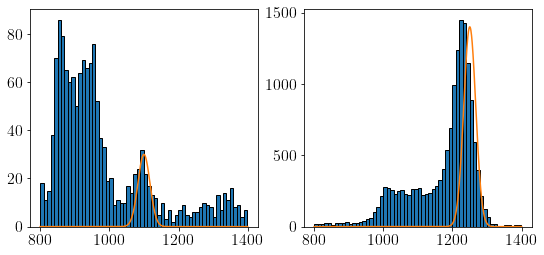

In [284]:
fig, ax = plt.subplots(1,2,figsize = [9,4])
histlinspace = np.linspace(800,1400,1000)

data880 = ax[0].hist(alphas880,bins=60,edgecolor='black')
ax[0].plot(histlinspace,gauss(histlinspace,30,1100,600))

data1045 = ax[1].hist(alphas1045,bins=60,edgecolor='black')
ax[1].plot(histlinspace,gauss(histlinspace,1400,1250,600))

In [319]:
def gauss(x,a,b,c):
    return a*np.exp(-(b-x)**2/c)

tofit880x = []
tofit880y = []

for i in range(len(data880[0])):
    if(data880[1][i] > 1050 and data880[1][i] < 1130):
        tofit880y.append(data880[0][i])
        tofit880x.append(data880[1][i])
        
tofit1045x = []
tofit1045y = []

for i in range(len(data1045[0])):
    if(data1045[1][i] > 1200 and data1045[1][i] < 1350):
        tofit1045y.append(data1045[0][i])
        tofit1045x.append(data1045[1][i])
        
popt1045, pcov = curve_fit(gauss,tofit1045x,tofit1045y,p0=[1200,1200,600],maxfev=100000)
popt880, pcov = curve_fit(gauss,tofit880x,tofit880y,p0=[30,1100,600],maxfev=100000)

In [320]:
popt880

array([  26.94159973, 1087.9395312 , 1434.49406265])

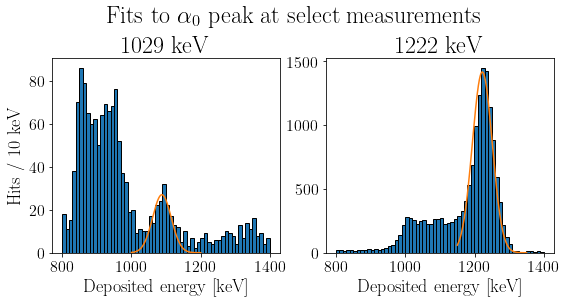

In [322]:
fig, ax = plt.subplots(1,2,figsize = [9,4])
histlinspace1 = np.linspace(1000,1200,1000)
histlinspace2 = np.linspace(1150,1350,1000)

data880 = ax[0].hist(alphas880,bins=60,edgecolor='black')
ax[0].plot(histlinspace1,gauss(histlinspace1,*popt880))
ax[0].set_xlabel('Deposited energy [keV]')
ax[0].set_ylabel('Hits / 10 keV')
ax[0].set_title('1029 keV')

data1045 = ax[1].hist(alphas1045,bins=60,edgecolor='black')
ax[1].plot(histlinspace2,gauss(histlinspace2,*popt1045))
ax[1].set_xlabel('Deposited energy [keV]')
ax[1].set_title('1222 keV')
fig.suptitle(r'Fits to $\alpha_0$ peak at select measurements')
fig.subplots_adjust(top=0.8)

plt.savefig('txtHists/a0peaks.png',dpi=300, bbox_inches = 'tight',facecolor='white', transparent=False)